In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline


voice = pd.read_csv("voice.csv")

voice.head(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


We're working with a dataset that contains various measurements of different voices, which we'll be using to train a model about whether or not that voice is male or female using decision trees and random forest models.

In [2]:
# Checking for nulls
voice.isnull().sum().sum()

0

In [3]:
# Creating separate DFs for X and Y
gender = pd.DataFrame(voice['label'])
decision_vars = voice.drop('label',axis=1)

# Creating decision tree
from sklearn import tree

# Computing cross validation
from sklearn.model_selection import cross_val_score

#Timing the model creation and visualization
import time
start_time = time.time()

# Model instantion & fit
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=5,
    #max_depth=10,
)
decision_tree.fit(decision_vars, gender)

#Cross validation
decision_cross_val = cross_val_score(decision_tree, decision_vars, gender, cv=5)
print(decision_cross_val)
print('Mean Accuracy: {}'.format(decision_cross_val.mean()))

# Outputting the time to run
print("\n--- Time to run: %s seconds ---" % (time.time() - start_time))

[ 0.92113565  0.97003155  0.97318612  0.98264984  0.95094937]
Mean Accuracy: 0.959590504332548

--- Time to run: 0.32249999046325684 seconds ---


The above model is quite accurate and runs in a pretty short amount of time (between 0.2 and 0.3 seconds depending on manipulation of depth and maximum features).

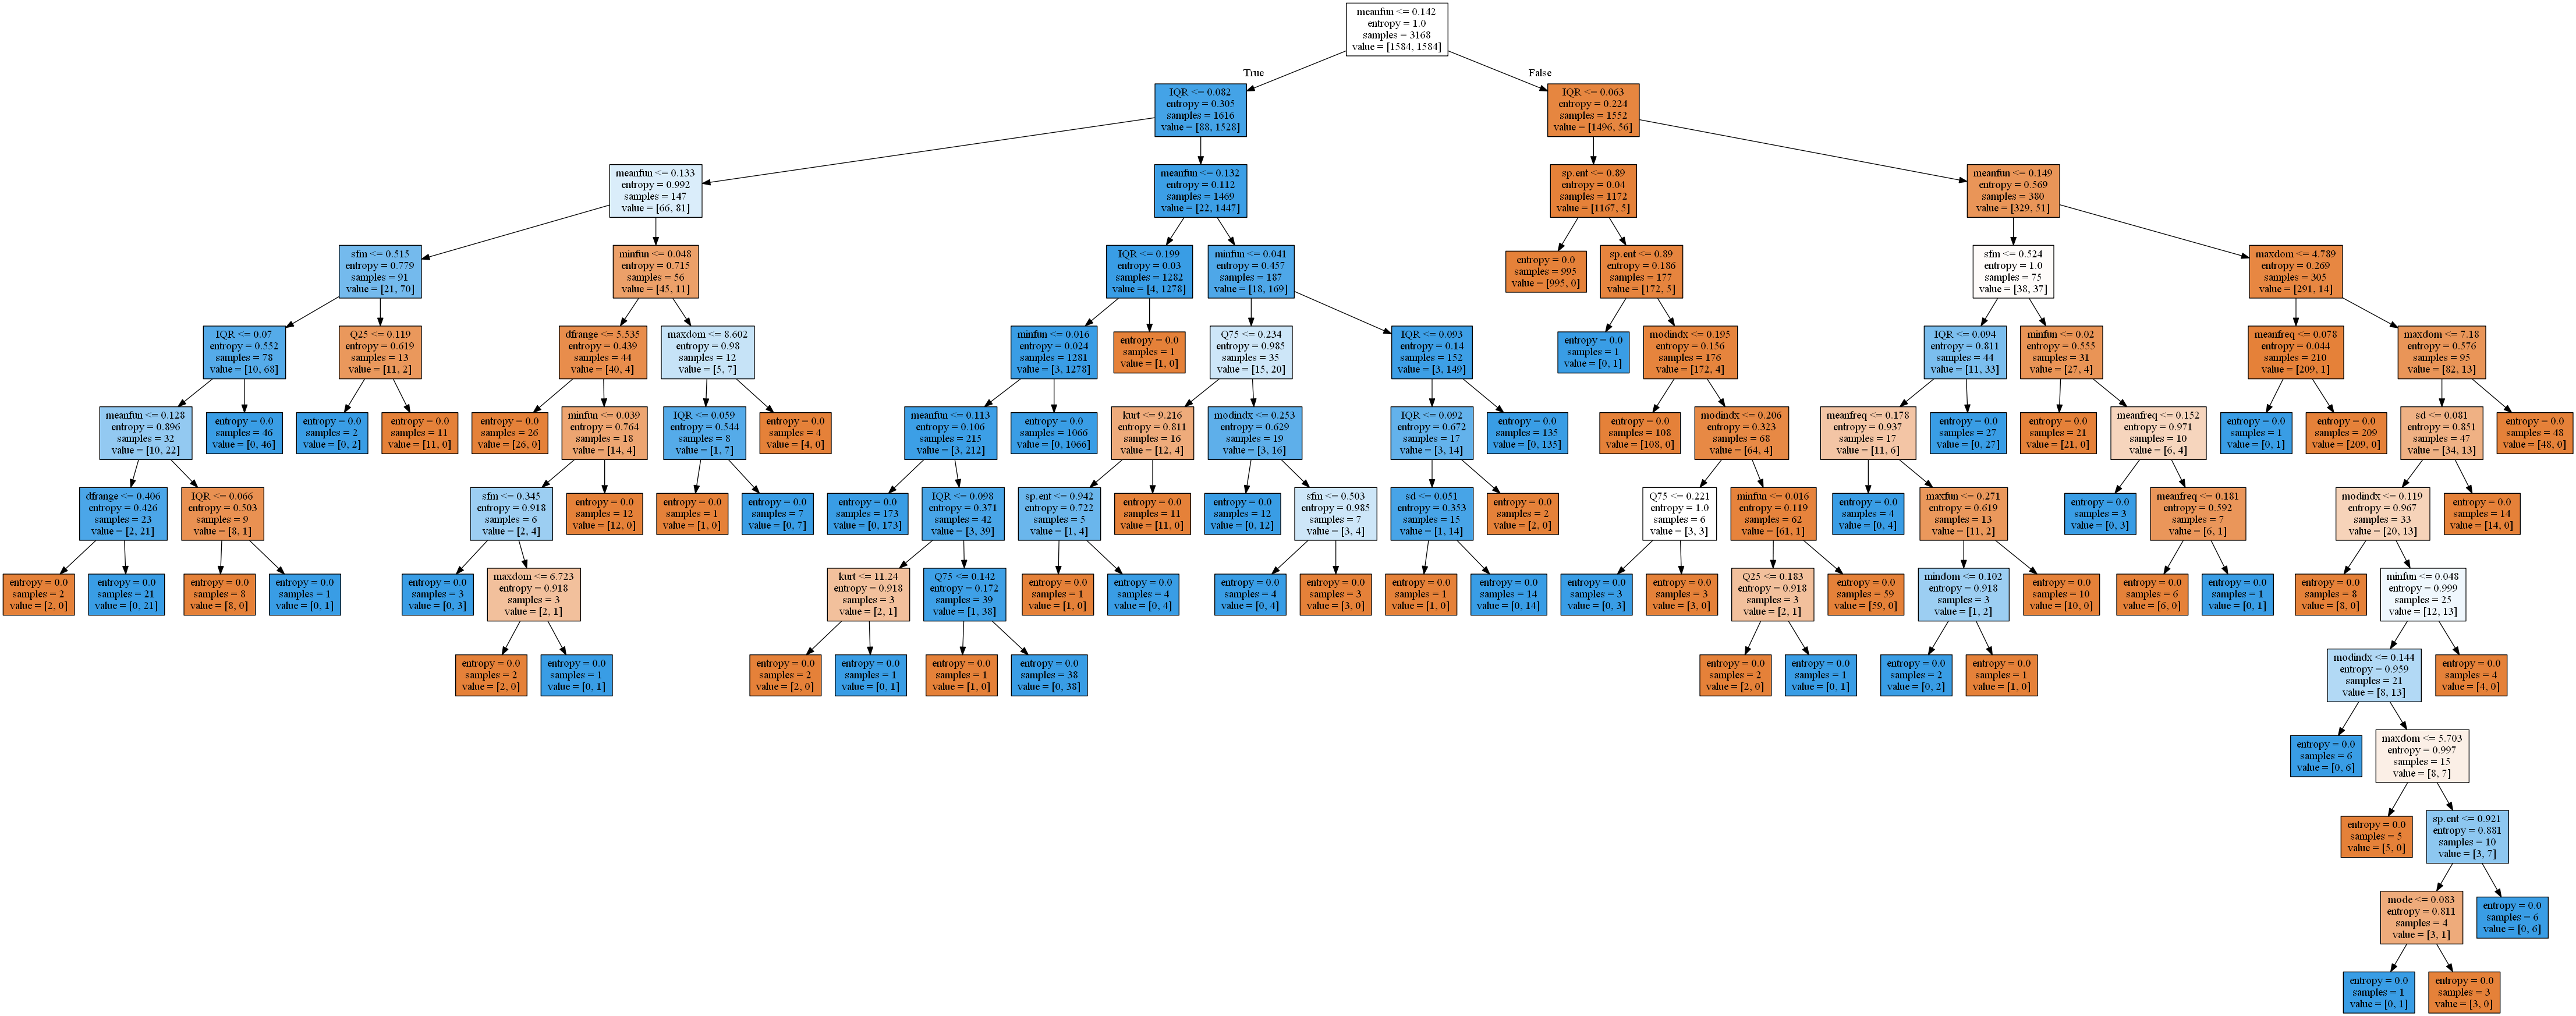

In [4]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=decision_vars.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [5]:
from sklearn import ensemble

#start timer
start_time = time.time()

# Model instantiation and fit
random_forest = ensemble.RandomForestClassifier()
X = decision_vars
Y = np.array(gender)
X = pd.get_dummies(X)

# Cross validation
decision_cross_val = cross_val_score(random_forest, decision_vars, gender.values.ravel(), cv=5)
print(decision_cross_val)
print('Mean Accuracy: {}'.format(decision_cross_val.mean()))

# end timer
print("\n--- Time to run: %s seconds ---" % (time.time() - start_time))

[ 0.93375394  0.96529968  0.97634069  0.98422713  0.95411392]
Mean Accuracy: 0.9627470750309467

--- Time to run: 0.45350003242492676 seconds ---


The random forest model represents a minor improvement on the decision tree in terms of accuracy, from about 95% to 96%. However, the model does take slightly longer to run (between 0.3 and 0.5 seconds depending on parameters). Let's see how the performance changes when we try to pare down the features using PCA.

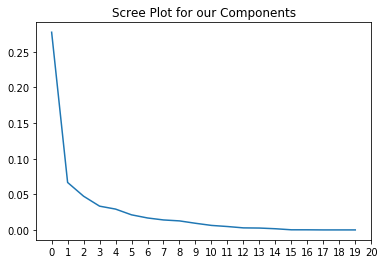

Percent of variance explained by component 
 [0.50779228659921016, 0.12190298129034158, 0.086562450625897763, 0.061035321596409842, 0.053497894220141028, 0.038744411834353759, 0.030699063287090381, 0.025599600255230295, 0.023177854180512637, 0.01706342612449762, 0.011573156750404974, 0.0087121606195822866, 0.0052350697733010145, 0.0048028935477510736, 0.0030122268144629903, 0.00030814939480620744, 0.00028105308600636649, 2.7409255048594506e-18, 5.2035782606707467e-23, 1.1553850927956605e-34]

 Eigenvalues: [0.2775498076921315, 0.066629899482770982, 0.047313423536778323, 0.033360770178223698, 0.02924095273714469, 0.021176974006021376, 0.016779536311439833, 0.013992264780978382, 0.012668583474555588, 0.009326550962679734, 0.0063256719631920267, 0.0047619047558643754, 0.002861391650049627, 0.0026251721731965416, 0.0016464270827712593, 0.00016842872080964494, 0.00015361838301005112, 1.4981388391443562e-18, 2.8441789756842839e-23, 6.3151197601568659e-35]


In [6]:
# Let's try PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

sklearn_pca = PCA(n_components=20)

pca_feat = X
X_normalized = MinMaxScaler().fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))

# Performing a scree plot to decide which ones to keep
sorted_eigenvals = sorted(component_variances,reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")
plt.xticks(np.arange(0, 21, 1.0))
plt.show()

print('Percent of variance explained by component \n',var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))

Let's take the first 3 components.

In [7]:
# Creating the corresponding DF
voice_pca = pd.DataFrame(X_PCA[:,0:3])
voice_pca.head(5)

,0,1,2
0,1.182596,-0.401103,0.487267
1,1.202886,-0.534895,0.546016
2,1.256645,-0.540784,0.761929
3,0.767548,0.041025,-0.159589
4,0.743572,0.353150,0.034173


Run the decision tree with these 3 components

In [8]:
# Trying the decision tree model with just these three components

#timer
start_time = time.time()

# Model instantion & fit
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy')
decision_tree.fit(voice_pca, gender)

#Cross validation
decision_cross_val = cross_val_score(decision_tree, voice_pca, gender, cv=5)
print(decision_cross_val)
print('Mean Accuracy: {}'.format(decision_cross_val.mean()))

# Outputting the time to run
print("\n--- Time to run: %s seconds ---" % (time.time() - start_time))

[ 0.70977918  0.71608833  0.86119874  0.89905363  0.75474684]
Mean Accuracy: 0.7881733418520145

--- Time to run: 0.18499994277954102 seconds ---


In [9]:
#timer
start_time = time.time()

#make predictions
decision_tree.predict(voice_pca)

# Outputting the time to run
print("\n--- Time to run: %s seconds ---" % (time.time() - start_time))


--- Time to run: 0.0005002021789550781 seconds ---


Run the random forest model with these 3 components

In [12]:
#start timer
start_time = time.time()

# Model instantiation and fit
random_forest = ensemble.RandomForestClassifier()
X = voice_pca
Y = np.array(gender)
X = pd.get_dummies(X)

# fit random forest
random_forest.fit(X, Y)

# Cross validation
decision_cross_val = cross_val_score(random_forest, voice_pca, gender.values.ravel(), cv=5)
print(decision_cross_val)
print('Mean Accuracy: {}'.format(decision_cross_val.mean()))

# end timer
print("\n--- Time to run: %s seconds ---" % (time.time() - start_time))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[ 0.70662461  0.75236593  0.88801262  0.92902208  0.84018987]
Mean Accuracy: 0.8232430220021563

--- Time to run: 0.4310002326965332 seconds ---


In [13]:
#timer
start_time = time.time()

#make predictions
random_forest.predict(voice_pca)

# Outputting the time to run
print("\n--- Time to run: %s seconds ---" % (time.time() - start_time))


--- Time to run: 0.0074999332427978516 seconds ---


# Conclusion
Random forest represents an improvement in accuracy and a slowdown in model runtime versus a decision tree in each iteration we tried. Which model is the best choice is situational. Since this dataset is not massive and there aren't too many variables, the slowdown in performance is not particularly important, and it may be better to go with the random forest model. If the dataset were many times bigger, this may not be the case. As we saw from the first example, the decision tree is quite accurate to begin with, and if running a random tree with the same specifications required substantial processing power, it may not be worth it considering it seems to only yield a ~1% performance increase.

The number of features to use is also a contextual decision. Since this model is easy to run and there are no huge outliers, it seems fine to use all features. If there were much more data, using something like PCA could come in handy. It is worth noting that the performance improvement of the random forest models increases as the "base" tree is simpler (eg using just a few PCA components). This is because a more simplistic, generalizable tree will benefit more from the iteration provided by the random forest. 

Note: the training of the model usually won't be done in a consumer-triggered process, but what we're really testing for is the time it takes to do the cross validation (make predictions).

Note: Best comparison to make is between the best possible versions of the decision trees and random forests. Tuning should always be done, especially for random forests which can be extremely sensitive to different parameters.

Why random trees are (usually) superior:
- Don't have pitfalls of possibly having a biased/flawed individual tree
- Less prone to overfitting because of its sampling (reduces randomness picked up on by high depth decision trees)

__Making a random edit to test git pushing!__
__And another one from my Windows machine!__